In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## llm 기반 감성분석 후처리
- 1. 파싱처리
- 2. 감성분석 결과 파일에 날짜 정보는 포함되어있지 않음.
  - 수집하고 전처리한 댓글데이터에서 날짜정보를 가져와서 포함시키기.
- 3. compound 계산하기
  - vader같은 경우 토큰별 intensity 점수를 가지고 특정 공식으로 compound를 계산한다고 함.
  - llm같은 경우 compound까지 요청하기에 할루시네이션 및 추론시간 상승이 걱정되었음.  
  (사실 compound까지 미처 생각하고 프롬프트에 추가안함. 추가했다면 결과가 어떨지 궁금함.but 내일이 발표..)
  - neg, neu, pos 정규화하고, 아래의 공식으로 감성지수를 나타낼 변수를 만들기
  <img width="500" alt="image" src="https://github.com/user-attachments/assets/3e19cde8-1ce3-4da9-b26a-3cfd32193df7">

In [ ]:
# "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis.jsonl"
# "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/harris_youtube_comment_filtered_for_llm_10000.jsonl"
# "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/trump_youtube_comment_filtered_for_llm_10000.jsonl"

In [2]:
import json
import os

## assistant_contents만 추출

In [3]:
input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis.jsonl"
output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents.jsonl"

In [4]:
# 파일이 존재하는지 확인
if not os.path.exists(input_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {input_path}")

with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
    for idx, line in enumerate(infile, 1):
        try:
            data = json.loads(line)
            outputs = data.get("output", [])
            # "assistant" 역할 찾기
            assistant_content = next((item["content"] for item in outputs if item.get("role") == "assistant"), None)
            if assistant_content:
                # "content"만 저장
                json.dump({"content": assistant_content}, outfile, ensure_ascii=False)
                outfile.write('\n')
        except json.JSONDecodeError as e:
            print(f"JSON 디코딩 오류 (라인 {idx}): {e}")
        except Exception as e:
            print(f"기타 오류 (라인 {idx}): {e}")


## source 필드 추가

In [5]:
input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents.jsonl"
output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_with_source.jsonl"

In [6]:
# 파일이 존재하는지 확인
if not os.path.exists(input_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {input_path}")

with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
    for idx, line in enumerate(infile, 1):
        try:
            data = json.loads(line)

            # 줄 번호에 따라 source 할당
            if 1 <= idx <= 10000:
                data['source'] = 'harris'
            elif 10001 <= idx <= 20000:
                data['source'] = 'trump'
            else:
                # 추가 줄이 있을 경우 처리 (선택사항)
                data['source'] = 'unknown'

            # 수정된 데이터를 새로운 파일에 씀
            json.dump(data, outfile, ensure_ascii=False)
            outfile.write('\n')

        except json.JSONDecodeError as e:
            print(f"JSON 디코딩 오류 (라인 {idx}): {e}")
        except Exception as e:
            print(f"기타 오류 (라인 {idx}): {e}")

##

In [7]:
import logging

In [8]:
# 입력 파일 경로
assistant_input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_with_source.jsonl"
harris_comments_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/harris_youtube_comment_filtered_for_llm_10000.jsonl"
trump_comments_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/trump_youtube_comment_filtered_for_llm_10000.jsonl"

# 출력 파일 경로
harris_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_harris_with_date.jsonl"
trump_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_trump_with_date.jsonl"

# 로그 파일 경로 (선택사항)
log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/split_add_date.log"

In [9]:
# 로깅 설정
logging.basicConfig(
    filename=log_path,
    filemode='w',  # 기존 로그를 덮어씀
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

In [10]:
# publishedAt 값 추출
def extract_published_at(file_path):
    published_at_list = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                data = json.loads(line)
                published_at = data.get("publishedAt", "")
                published_at_list.append(published_at)
            except json.JSONDecodeError as e:
                logging.error(f"JSON 디코딩 오류 (파일: {file_path}, 라인 {idx}): {e}")
                published_at_list.append("")  # 빈 문자열로 대체
            except Exception as e:
                logging.error(f"기타 오류 (파일: {file_path}, 라인 {idx}): {e}")
                published_at_list.append("")  # 빈 문자열로 대체
    return published_at_list

# `harris`와 `trump`의 `publishedAt` 리스트 추출
harris_published_at = extract_published_at(harris_comments_path)
trump_published_at = extract_published_at(trump_comments_path)

# 예상되는 줄 수 확인
if len(harris_published_at) != 10000:
    logging.error(f"'harris_youtube_comment_filtered_for_llm_10000.jsonl' 파일의 줄 수가 10,000이 아닙니다: {len(harris_published_at)}줄")
if len(trump_published_at) != 10000:
    logging.error(f"'trump_youtube_comment_filtered_for_llm_10000.jsonl' 파일의 줄 수가 10,000이 아닙니다: {len(trump_published_at)}줄")


In [11]:
# assistant_contents_with_source.jsonl 파일을 읽어 별도의 파일로 저장
# 파일 존재 여부 확인
if not os.path.exists(assistant_input_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {assistant_input_path}")
if not os.path.exists(harris_comments_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {harris_comments_path}")
if not os.path.exists(trump_comments_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {trump_comments_path}")

# 출력 파일 열기
with open(assistant_input_path, 'r', encoding='utf-8') as infile, \
     open(harris_output_path, 'w', encoding='utf-8') as harris_outfile, \
     open(trump_output_path, 'w', encoding='utf-8') as trump_outfile:

    for idx, line in enumerate(infile, 1):
        try:
            data = json.loads(line)

            # 1~10,000줄: harris
            if 1 <= idx <= 10000:
                if idx <= len(harris_published_at):
                    data['date'] = harris_published_at[idx - 1]
                else:
                    data['date'] = ""  # 데이터 부족 시 빈 문자열
                    logging.error(f"harris_published_at 리스트에 해당 인덱스가 없습니다: {idx}")

                # harris_output 파일에 씀
                json.dump(data, harris_outfile, ensure_ascii=False)
                harris_outfile.write('\n')

            # 10,001~20,000줄: trump
            elif 10001 <= idx <= 20000:
                trump_idx = idx - 10000
                if trump_idx <= len(trump_published_at):
                    data['date'] = trump_published_at[trump_idx - 1]
                else:
                    data['date'] = ""  # 데이터 부족 시 빈 문자열
                    logging.error(f"trump_published_at 리스트에 해당 인덱스가 없습니다: {trump_idx}")

                # trump_output 파일에 씀
                json.dump(data, trump_outfile, ensure_ascii=False)
                trump_outfile.write('\n')

            else:
                # 추가 줄이 있을 경우 처리 (선택사항)
                data['date'] = "unknown"
                logging.warning(f"예상 범위를 벗어난 줄 번호: {idx}")
                # 필요 시 별도의 파일에 기록하거나 무시할 수 있습니다.

        except json.JSONDecodeError as e:
            logging.error(f"JSON 디코딩 오류 (파일: {assistant_input_path}, 라인 {idx}): {e}")
        except Exception as e:
            logging.error(f"기타 오류 (파일: {assistant_input_path}, 라인 {idx}): {e}")


In [12]:
# 별도의 파일이 아닌 하나의 파일로 저장

# 1. 로깅 설정
log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/add_date.log"
logging.basicConfig(
    filename=log_path,
    filemode='w',
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# 2. 파일 경로 설정
assistant_input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_with_source.jsonl"
harris_comments_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/harris_youtube_comment_filtered_for_llm_10000.jsonl"
trump_comments_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/trump_youtube_comment_filtered_for_llm_10000.jsonl"
output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_with_source_and_date.jsonl"

# 3. `publishedAt` 추출 함수
def extract_published_at(file_path):
    published_at_list = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                data = json.loads(line)
                published_at = data.get("publishedAt", "")
                published_at_list.append(published_at)
            except json.JSONDecodeError as e:
                logging.error(f"JSON 디코딩 오류 (파일: {file_path}, 라인 {idx}): {e}")
                published_at_list.append("")  # 빈 문자열로 대체
            except Exception as e:
                logging.error(f"기타 오류 (파일: {file_path}, 라인 {idx}): {e}")
                published_at_list.append("")  # 빈 문자열로 대체
    return published_at_list

# 4. `harris`와 `trump`의 `publishedAt` 리스트 추출
harris_published_at = extract_published_at(harris_comments_path)
trump_published_at = extract_published_at(trump_comments_path)

# 5. 예상되는 줄 수 확인
if len(harris_published_at) != 10000:
    logging.error(f"'harris_youtube_comment_filtered_for_llm_10000.jsonl' 파일의 줄 수가 10,000이 아닙니다: {len(harris_published_at)}줄")
if len(trump_published_at) != 10000:
    logging.error(f"'trump_youtube_comment_filtered_for_llm_10000.jsonl' 파일의 줄 수가 10,000이 아닙니다: {len(trump_published_at)}줄")

# 6. `assistant_contents_with_source.jsonl` 파일에 `date` 필드 추가
if not os.path.exists(assistant_input_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {assistant_input_path}")
if not os.path.exists(harris_comments_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {harris_comments_path}")
if not os.path.exists(trump_comments_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {trump_comments_path}")

with open(assistant_input_path, 'r', encoding='utf-8') as infile, \
     open(output_path, 'w', encoding='utf-8') as outfile:

    for idx, line in enumerate(infile, 1):
        try:
            data = json.loads(line)

            # 1~10,000줄: harris
            if 1 <= idx <= 10000:
                if idx <= len(harris_published_at):
                    data['date'] = harris_published_at[idx - 1]
                else:
                    data['date'] = ""  # 데이터 부족 시 빈 문자열
                    logging.error(f"harris_published_at 리스트에 해당 인덱스가 없습니다: {idx}")

            # 10,001~20,000줄: trump
            elif 10001 <= idx <= 20000:
                trump_idx = idx - 10000
                if trump_idx <= len(trump_published_at):
                    data['date'] = trump_published_at[trump_idx - 1]
                else:
                    data['date'] = ""  # 데이터 부족 시 빈 문자열
                    logging.error(f"trump_published_at 리스트에 해당 인덱스가 없습니다: {trump_idx}")

            else:
                # 추가 줄이 있을 경우 처리 (선택사항)
                data['date'] = "unknown"
                logging.warning(f"예상 범위를 벗어난 줄 번호: {idx}")

            # 수정된 데이터를 새로운 파일에 씀
            json.dump(data, outfile, ensure_ascii=False)
            outfile.write('\n')

        except json.JSONDecodeError as e:
            logging.error(f"JSON 디코딩 오류 (파일: {assistant_input_path}, 라인 {idx}): {e}")
        except Exception as e:
            logging.error(f"기타 오류 (파일: {assistant_input_path}, 라인 {idx}): {e}")


## harris score값과 trump score값을 보고 어떤 후보자에 대한 댓글을 작성한건지 분리

In [13]:
# 입력 파일 경로
input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/assistant_contents_with_source_and_date.jsonl"

# 출력 파일 경로
harris_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris.json"
trump_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump.json"
equal_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_equal.json"

# 로그 파일 경로 (선택사항)
log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/split_sentiment_analysis.log"


In [14]:
# 로깅 설정
logging.basicConfig(
    filename=log_path,
    filemode='w',  # 기존 로그를 덮어씀
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)


In [15]:
# 파일 존재 여부 확인
if not os.path.exists(input_path):
    raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {input_path}")

# 출력 파일 열기
with open(input_path, 'r', encoding='utf-8') as infile, \
     open(harris_output_path, 'w', encoding='utf-8') as harris_outfile, \
     open(trump_output_path, 'w', encoding='utf-8') as trump_outfile, \
     open(equal_output_path, 'w', encoding='utf-8') as equal_outfile:

    for idx, line in enumerate(infile, 1):
        try:
            # 각 줄을 JSON 객체로 파싱
            data = json.loads(line)

            # "content" 필드의 JSON 문자열을 파싱
            content_str = data.get("content", "")
            if not content_str:
                logging.error(f"라인 {idx}: 'content' 필드가 비어 있습니다.")
                continue  # 다음 줄로 이동

            try:
                content_json = json.loads(content_str)
            except json.JSONDecodeError as e:
                logging.error(f"라인 {idx}: 'content' 필드의 JSON 디코딩 오류: {e}")
                continue  # 다음 줄로 이동

            # "harris score"와 "trump score" 추출
            harris_score = content_json.get("harris score", None)
            trump_score = content_json.get("trump score", None)

            if harris_score is None or trump_score is None:
                logging.error(f"라인 {idx}: 'harris score' 또는 'trump score' 필드가 없습니다.")
                continue  # 다음 줄로 이동

            # 조건에 따라 해당 출력 파일에 저장
            if harris_score > trump_score:
                json.dump(data, harris_outfile, ensure_ascii=False)
                harris_outfile.write('\n')
            elif trump_score > harris_score:
                json.dump(data, trump_outfile, ensure_ascii=False)
                trump_outfile.write('\n')
            else:  # harris_score == trump_score
                json.dump(data, equal_outfile, ensure_ascii=False)
                equal_outfile.write('\n')

        except json.JSONDecodeError as e:
            logging.error(f"라인 {idx}: JSON 디코딩 오류: {e}")
        except Exception as e:
            logging.error(f"라인 {idx}: 기타 오류: {e}")


ERROR:root:라인 3705: 'content' 필드의 JSON 디코딩 오류: Expecting ',' delimiter: line 6 column 39 (char 197)
ERROR:root:라인 19156: 'content' 필드의 JSON 디코딩 오류: Expecting ',' delimiter: line 6 column 25 (char 127)
ERROR:root:라인 19301: 'content' 필드의 JSON 디코딩 오류: Expecting value: line 1 column 1 (char 0)


In [16]:
# 파일 경로 설정
harris_file = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris.json"
trump_file = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump.json"
equal_file = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_equal.json"

def count_lines(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1
    return count

harris_count = count_lines(harris_file)
trump_count = count_lines(trump_file)
equal_count = count_lines(equal_file)

print(f"'llm_sentiment_analysis_harris.json'의 개수: {harris_count}개")
print(f"'llm_sentiment_analysis_trump.json'의 개수: {trump_count}개")
print(f"'llm_sentiment_analysis_equal.json'의 개수: {equal_count}개")

'llm_sentiment_analysis_harris.json'의 개수: 10065개
'llm_sentiment_analysis_trump.json'의 개수: 9913개
'llm_sentiment_analysis_equal.json'의 개수: 19개


## 다운샘플링

In [17]:
import random

In [18]:
# 2. 로깅 설정
log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/downsampling_log.log"
logging.basicConfig(
    filename=log_path,
    filemode='w',
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# 3. 파일 경로 설정
input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris.json"
output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_downsampled.json"

# 4. 데이터 읽기 함수
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError as e:
                logging.error(f"JSON 디코딩 오류 (파일: {file_path}, 라인 {idx}): {e}")
            except Exception as e:
                logging.error(f"기타 오류 (파일: {file_path}, 라인 {idx}): {e}")
    return data

# 5. 데이터 읽기
harris_data = read_jsonl(input_path)
total_harris = len(harris_data)
print(f"'llm_sentiment_analysis_harris.json'의 전체 개수: {total_harris}개")

# 6. 랜덤 샘플링
random.seed(42)
target_count = 9913

if total_harris < target_count:
    logging.error(f"원본 데이터의 개수({total_harris})가 타겟 개수({target_count})보다 작습니다.")
    raise ValueError("다운샘플링할 타겟 개수가 원본 데이터보다 큽니다.")
else:
    downsampled_harris = random.sample(harris_data, target_count)
    print(f"'llm_sentiment_analysis_harris_downsampled.json'에 저장할 데이터 개수: {len(downsampled_harris)}개")

# 7. 데이터 저장 함수
def write_jsonl(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        for entry in data:
            json.dump(entry, f, ensure_ascii=False)
            f.write('\n')

# 8. 샘플링된 데이터 저장
write_jsonl(downsampled_harris, output_path)
print(f"다운샘플링된 데이터가 '{output_path}'에 저장되었습니다.")

'llm_sentiment_analysis_harris.json'의 전체 개수: 10065개
'llm_sentiment_analysis_harris_downsampled.json'에 저장할 데이터 개수: 9913개
다운샘플링된 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_downsampled.json'에 저장되었습니다.


In [19]:
# 파일 경로 설정
harris_file = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_downsampled.json"
trump_file = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump.json"

def count_lines(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1
    return count

harris_count = count_lines(harris_file)
trump_count = count_lines(trump_file)

print(f"'llm_sentiment_analysis_harris_downsampled.json'의 개수: {harris_count}개")
print(f"'llm_sentiment_analysis_trump.json'의 개수: {trump_count}개")

'llm_sentiment_analysis_harris_downsampled.json'의 개수: 9913개
'llm_sentiment_analysis_trump.json'의 개수: 9913개


## 정규화

In [20]:
# 2. 로깅 설정
log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/normalization_log.log"
logging.basicConfig(
    filename=log_path,
    filemode='w',  # 기존 로그를 덮어씀
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# 3. 파일 경로 설정
input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_downsampled.json"
output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_normalized.json"

# 4. 데이터 읽기 함수
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError as e:
                logging.error(f"JSON 디코딩 오류 (파일: {file_path}, 라인 {idx}): {e}")
            except Exception as e:
                logging.error(f"기타 오류 (파일: {file_path}, 라인 {idx}): {e}")
    return data

# 5. 데이터 읽기
harris_data = read_jsonl(input_path)
total_harris = len(harris_data)
print(f"'llm_sentiment_analysis_harris_downsampled.json'의 전체 개수: {total_harris}개")

# 6. 점수 정규화 함수
def normalize_scores(content_str, idx):
    """
    주어진 content JSON 문자열에서 'positive score', 'neutrality score', 'negative score'을 정규화합니다.
    새로운 필드 'normalized_positive score', 'normalized_neutrality score', 'normalized_negative score'을 추가합니다.
    """
    try:
        content_json = json.loads(content_str)
    except json.JSONDecodeError as e:
        logging.error(f"라인 {idx}: 'content' 필드의 JSON 디코딩 오류: {e}")
        return None  # 정규화 불가

    # 점수 추출
    pos = content_json.get("positive score", None)
    neu = content_json.get("neutrality score", None)
    neg = content_json.get("negative score", None)

    if pos is None or neu is None or neg is None:
        logging.error(f"라인 {idx}: 'positive score', 'neutrality score', 또는 'negative score' 필드가 없습니다.")
        return None  # 정규화 불가

    # 음수 점수 처리: 음수가 있을 경우 0으로 설정하고 로그 기록
    if pos < 0:
        logging.error(f"라인 {idx}: 'positive score'가 음수입니다: {pos}. 0으로 설정합니다.")
        pos = 0.0
    if neu < 0:
        logging.error(f"라인 {idx}: 'neutrality score'가 음수입니다: {neu}. 0으로 설정합니다.")
        neu = 0.0
    if neg < 0:
        logging.error(f"라인 {idx}: 'negative score'가 음수입니다: {neg}. 0으로 설정합니다.")
        neg = 0.0

    total = pos + neu + neg

    if total == 0:
        logging.error(f"라인 {idx}: 점수의 합이 0입니다. 모든 정규화 점수를 0으로 설정합니다.")
        normalized_pos = 0.0
        normalized_neu = 0.0
        normalized_neg = 0.0
    else:
        normalized_pos = pos / total
        normalized_neu = neu / total
        normalized_neg = neg / total

    # 소수점 4자리로 반올림 (선택사항)
    normalized_pos = round(normalized_pos, 4)
    normalized_neu = round(normalized_neu, 4)
    normalized_neg = round(normalized_neg, 4)

    # 정규화된 점수 필드 추가
    content_json["normalized_positive score"] = normalized_pos
    content_json["normalized_neutrality score"] = normalized_neu
    content_json["normalized_negative score"] = normalized_neg

    # 업데이트된 content JSON 문자열 반환
    updated_content_str = json.dumps(content_json, ensure_ascii=False)
    return updated_content_str

# 7. 정규화 및 필드 추가 수행
normalized_data = []

for idx, entry in enumerate(harris_data, 1):
    content_str = entry.get("content", "")
    if not content_str:
        logging.error(f"라인 {idx}: 'content' 필드가 비어 있습니다.")
        continue  # 다음 데이터로 이동

    normalized_content = normalize_scores(content_str, idx)
    if normalized_content is None:
        continue  # 정규화 불가, 다음 데이터로 이동

    # 업데이트된 content 문자열을 다시 할당
    entry["content"] = normalized_content

    # 정규화된 데이터 리스트에 추가
    normalized_data.append(entry)

print(f"정규화된 데이터 개수: {len(normalized_data)}개")

# 8. 데이터 저장 함수
def write_jsonl(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        for entry in data:
            json.dump(entry, f, ensure_ascii=False)
            f.write('\n')

# 9. 정규화된 데이터 저장
write_jsonl(normalized_data, output_path)
print(f"정규화된 데이터가 '{output_path}'에 저장되었습니다.")

ERROR:root:라인 14: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 83: 'negative score'가 음수입니다: -0.5. 0으로 설정합니다.
ERROR:root:라인 110: 'negative score'가 음수입니다: -0.21. 0으로 설정합니다.
ERROR:root:라인 154: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 196: 'negative score'가 음수입니다: -0.05. 0으로 설정합니다.
ERROR:root:라인 197: 'negative score'가 음수입니다: -0.3. 0으로 설정합니다.
ERROR:root:라인 203: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 224: 'negative score'가 음수입니다: -0.05. 0으로 설정합니다.
ERROR:root:라인 357: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 413: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 441: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 457: 'negative score'가 음수입니다: -0.15. 0으로 설정합니다.
ERROR:root:라인 476: 'negative score'가 음수입니다: -0.6. 0으로 설정합니다.
ERROR:root:라인 489: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 492: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 505: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 571: 'ne

'llm_sentiment_analysis_harris_downsampled.json'의 전체 개수: 9913개


ERROR:root:라인 953: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 957: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 972: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 990: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 1033: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 1036: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1042: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 1047: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1074: 'negative score'가 음수입니다: -0.42. 0으로 설정합니다.
ERROR:root:라인 1094: 'negative score'가 음수입니다: -0.3. 0으로 설정합니다.
ERROR:root:라인 1108: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1123: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1132: 'negative score'가 음수입니다: -0.4. 0으로 설정합니다.
ERROR:root:라인 1153: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1172: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1200: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:

정규화된 데이터 개수: 9913개
정규화된 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_normalized.json'에 저장되었습니다.


In [21]:
# 2. 로깅 설정
log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/normalization_trump_log.log"
logging.basicConfig(
    filename=log_path,
    filemode='w',  # 기존 로그를 덮어씀
    level=logging.ERROR,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# 3. 파일 경로 설정
input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump.json"
output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_normalized.json"

# 4. 데이터 읽기 함수
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError as e:
                logging.error(f"JSON 디코딩 오류 (파일: {file_path}, 라인 {idx}): {e}")
            except Exception as e:
                logging.error(f"기타 오류 (파일: {file_path}, 라인 {idx}): {e}")
    return data

# 5. 데이터 읽기
trump_data = read_jsonl(input_path)
total_trump = len(trump_data)
print(f"'llm_sentiment_analysis_trump.json'의 전체 개수: {total_trump}개")

# 6. 점수 정규화 함수
def normalize_scores(content_str, idx):
    """
    주어진 content JSON 문자열에서 'positive score', 'neutrality score', 'negative score'을 정규화합니다.
    새로운 필드 'normalized_positive score', 'normalized_neutrality score', 'normalized_negative score'을 추가합니다.
    """
    try:
        content_json = json.loads(content_str)
    except json.JSONDecodeError as e:
        logging.error(f"라인 {idx}: 'content' 필드의 JSON 디코딩 오류: {e}")
        return None  # 정규화 불가

    # 점수 추출
    pos = content_json.get("positive score", None)
    neu = content_json.get("neutrality score", None)
    neg = content_json.get("negative score", None)

    if pos is None or neu is None or neg is None:
        logging.error(f"라인 {idx}: 'positive score', 'neutrality score', 또는 'negative score' 필드가 없습니다.")
        return None  # 정규화 불가

    # 음수 점수 처리: 음수가 있을 경우 0으로 설정하고 로그 기록
    if pos < 0:
        logging.error(f"라인 {idx}: 'positive score'가 음수입니다: {pos}. 0으로 설정합니다.")
        pos = 0.0
    if neu < 0:
        logging.error(f"라인 {idx}: 'neutrality score'가 음수입니다: {neu}. 0으로 설정합니다.")
        neu = 0.0
    if neg < 0:
        logging.error(f"라인 {idx}: 'negative score'가 음수입니다: {neg}. 0으로 설정합니다.")
        neg = 0.0

    total = pos + neu + neg

    if total == 0:
        logging.error(f"라인 {idx}: 점수의 합이 0입니다. 모든 정규화 점수를 0으로 설정합니다.")
        normalized_pos = 0.0
        normalized_neu = 0.0
        normalized_neg = 0.0
    else:
        normalized_pos = pos / total
        normalized_neu = neu / total
        normalized_neg = neg / total

    # 소수점 4자리로 반올림 (선택사항)
    normalized_pos = round(normalized_pos, 4)
    normalized_neu = round(normalized_neu, 4)
    normalized_neg = round(normalized_neg, 4)

    # 정규화된 점수 필드 추가
    content_json["normalized_positive score"] = normalized_pos
    content_json["normalized_neutrality score"] = normalized_neu
    content_json["normalized_negative score"] = normalized_neg

    # 업데이트된 content JSON 문자열 반환
    updated_content_str = json.dumps(content_json, ensure_ascii=False)
    return updated_content_str

# 7. 정규화 및 필드 추가 수행
normalized_data = []

for idx, entry in enumerate(trump_data, 1):
    content_str = entry.get("content", "")
    if not content_str:
        logging.error(f"라인 {idx}: 'content' 필드가 비어 있습니다.")
        continue  # 다음 데이터로 이동

    normalized_content = normalize_scores(content_str, idx)
    if normalized_content is None:
        continue  # 정규화 불가, 다음 데이터로 이동

    # 업데이트된 content 문자열을 다시 할당
    entry["content"] = normalized_content

    # 정규화된 데이터 리스트에 추가
    normalized_data.append(entry)

print(f"정규화된 데이터 개수: {len(normalized_data)}개")

# 8. 데이터 저장 함수
def write_jsonl(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        for entry in data:
            json.dump(entry, f, ensure_ascii=False)
            f.write('\n')

# 9. 정규화된 데이터 저장
write_jsonl(normalized_data, output_path)
print(f"정규화된 데이터가 '{output_path}'에 저장되었습니다.")

ERROR:root:라인 13: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 21: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 24: 'negative score'가 음수입니다: -0.17. 0으로 설정합니다.
ERROR:root:라인 28: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 30: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 33: 'negative score'가 음수입니다: -0.3. 0으로 설정합니다.
ERROR:root:라인 35: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 43: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 50: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 52: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 86: 'negative score'가 음수입니다: -0.3. 0으로 설정합니다.
ERROR:root:라인 116: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 141: 'negative score'가 음수입니다: -0.3. 0으로 설정합니다.
ERROR:root:라인 165: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 168: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 187: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 197: 'negative score

'llm_sentiment_analysis_trump.json'의 전체 개수: 9913개


ERROR:root:라인 837: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 842: 'negative score'가 음수입니다: -0.25. 0으로 설정합니다.
ERROR:root:라인 878: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 902: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 917: 'negative score'가 음수입니다: -0.05. 0으로 설정합니다.
ERROR:root:라인 945: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 955: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 957: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 963: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 968: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 970: 'negative score'가 음수입니다: -0.3. 0으로 설정합니다.
ERROR:root:라인 993: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1021: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1026: 'negative score'가 음수입니다: -0.1. 0으로 설정합니다.
ERROR:root:라인 1033: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1056: 'negative score'가 음수입니다: -0.2. 0으로 설정합니다.
ERROR:root:라인 1070

정규화된 데이터 개수: 9913개
정규화된 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_normalized.json'에 저장되었습니다.


## sentiment score 계산후 필드 추가

In [22]:
# 2. 로깅 설정
# Harris 로깅 설정
harris_log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/harris_normalization_sentiment_log.log"
harris_logger = logging.getLogger('harris_logger')
harris_logger.setLevel(logging.ERROR)
harris_handler = logging.FileHandler(harris_log_path, mode='w')
harris_handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(message)s'))
harris_logger.addHandler(harris_handler)

# Trump 로깅 설정
trump_log_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/trump_normalization_sentiment_log.log"
trump_logger = logging.getLogger('trump_logger')
trump_logger.setLevel(logging.ERROR)
trump_handler = logging.FileHandler(trump_log_path, mode='w')
trump_handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(message)s'))
trump_logger.addHandler(trump_handler)

# 3. 파일 경로 설정
harris_input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_normalized.json"
harris_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_normalized_with_sentiment.json"

trump_input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_normalized.json"
trump_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_normalized_with_sentiment.json"

# 4. 데이터 읽기 함수
def read_jsonl(file_path, logger=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f, 1):
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError as e:
                if logger:
                    logger.error(f"JSON 디코딩 오류 (파일: {file_path}, 라인 {idx}): {e}")
            except Exception as e:
                if logger:
                    logger.error(f"기타 오류 (파일: {file_path}, 라인 {idx}): {e}")
    return data

# 5. 데이터 읽기
harris_data = read_jsonl(harris_input_path, logger=harris_logger)
total_harris = len(harris_data)
print(f"'llm_sentiment_analysis_harris_normalized.json'의 전체 개수: {total_harris}개")

trump_data = read_jsonl(trump_input_path, logger=trump_logger)
total_trump = len(trump_data)
print(f"'llm_sentiment_analysis_trump_normalized.json'의 전체 개수: {total_trump}개")

# 6. 정규화 및 필드 추가 함수
def add_sentiment_score(entry, idx, logger=None):
    """
    주어진 JSON 객체에 'sentiment score' 필드를 추가합니다.
    """
    content_str = entry.get("content", "")
    if not content_str:
        if logger:
            logger.error(f"라인 {idx}: 'content' 필드가 비어 있습니다.")
        return None  # 필드 추가 불가

    try:
        content_json = json.loads(content_str)
    except json.JSONDecodeError as e:
        if logger:
            logger.error(f"라인 {idx}: 'content' 필드의 JSON 디코딩 오류: {e}")
        return None  # 필드 추가 불가

    # 정규화된 점수 추출
    pos = content_json.get("normalized_positive score", None)
    neu = content_json.get("normalized_neutrality score", None)
    neg = content_json.get("normalized_negative score", None)

    if pos is None or neu is None or neg is None:
        if logger:
            logger.error(f"라인 {idx}: 'normalized_positive score', 'normalized_neutrality score', 또는 'normalized_negative score' 필드가 없습니다.")
        return None  # 필드 추가 불가

    # 점수 합이 1인지 확인 (선택사항)
    total = pos + neu + neg
    if not abs(total - 1.0) < 1e-6:
        if logger:
            logger.warning(f"라인 {idx}: 정규화된 점수의 합이 1이 아닙니다: {total}")

    # 'sentiment score' 계산
    sentiment_score = (pos - neg) * (1 - neu)

    # 소수점 4자리로 반올림 (선택사항)
    sentiment_score = round(sentiment_score, 4)

    # 새로운 필드 추가
    content_json["sentiment score"] = sentiment_score

    # 업데이트된 content JSON 문자열 반환
    updated_content_str = json.dumps(content_json, ensure_ascii=False)
    return updated_content_str

# 7. 정규화 및 필드 추가 수행

# Harris 파일 처리
normalized_harris_data = []
for idx, entry in enumerate(harris_data, 1):
    updated_content = add_sentiment_score(entry, idx, logger=harris_logger)
    if updated_content is None:
        continue  # 필드 추가 실패 시 해당 데이터는 제외
    entry["content"] = updated_content
    normalized_harris_data.append(entry)

print(f"'llm_sentiment_analysis_harris_normalized_with_sentiment.json'에 저장할 데이터 개수: {len(normalized_harris_data)}개")

# Trump 파일 처리
normalized_trump_data = []
for idx, entry in enumerate(trump_data, 1):
    updated_content = add_sentiment_score(entry, idx, logger=trump_logger)
    if updated_content is None:
        continue  # 필드 추가 실패 시 해당 데이터는 제외
    entry["content"] = updated_content
    normalized_trump_data.append(entry)

print(f"'llm_sentiment_analysis_trump_normalized_with_sentiment.json'에 저장할 데이터 개수: {len(normalized_trump_data)}개")

# 8. 데이터 저장 함수
def write_jsonl(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        for entry in data:
            json.dump(entry, f, ensure_ascii=False)
            f.write('\n')

# 9. 정규화된 데이터 저장

# Harris 파일 저장
write_jsonl(normalized_harris_data, harris_output_path)
print(f"정규화된 Harris 데이터가 '{harris_output_path}'에 저장되었습니다.")

# Trump 파일 저장
write_jsonl(normalized_trump_data, trump_output_path)
print(f"정규화된 Trump 데이터가 '{trump_output_path}'에 저장되었습니다.")

'llm_sentiment_analysis_harris_normalized.json'의 전체 개수: 9913개
'llm_sentiment_analysis_trump_normalized.json'의 전체 개수: 9913개
'llm_sentiment_analysis_harris_normalized_with_sentiment.json'에 저장할 데이터 개수: 9913개
'llm_sentiment_analysis_trump_normalized_with_sentiment.json'에 저장할 데이터 개수: 9913개
정규화된 Harris 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_normalized_with_sentiment.json'에 저장되었습니다.
정규화된 Trump 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_normalized_with_sentiment.json'에 저장되었습니다.


## 시계열 데이터로 변환

In [23]:
from datetime import datetime
from collections import defaultdict

In [25]:
def aggregate_sentiment_scores(input_file_path):
    """
    입력 JSONL 파일에서 날짜별로 sentiment score를 집계하여 평균을 계산합니다.

    Args:
        input_file_path (str): 입력 JSONL 파일의 경로

    Returns:
        dict: 날짜별 평균 sentiment score을 가진 딕셔너리
    """
    date_sentiment_dict = defaultdict(list)

    with open(input_file_path, 'r', encoding='utf-8') as infile:
        for idx, line in enumerate(infile, 1):
            try:
                entry = json.loads(line)

                # 'date'와 'sentiment score' 추출
                date_str = entry.get("date", "")
                sentiment_score = None

                if not date_str:
                    print(f"라인 {idx}: 'date' 필드가 누락되었습니다. 건너뜁니다.")
                    continue

                # 'sentiment score' 추출: 'content' 필드 내의 JSON 문자열에서
                content_str = entry.get("content", "")
                if not content_str:
                    print(f"라인 {idx}: 'content' 필드가 비어 있습니다. 건너뜁니다.")
                    continue

                try:
                    content_json = json.loads(content_str)
                    sentiment_score = content_json.get("sentiment score", None)

                    if sentiment_score is None:
                        print(f"라인 {idx}: 'sentiment score' 필드가 누락되었습니다. 건너뜁니다.")
                        continue
                except json.JSONDecodeError as e:
                    print(f"라인 {idx}: 'content' 필드의 JSON 디코딩 오류: {e}. 건너뜁니다.")
                    continue

                # 날짜 형식 변환 및 날짜 부분만 추출 (YYYY-MM-DD)
                try:
                    date_obj = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
                    date_only = date_obj.strftime('%Y-%m-%d')
                except ValueError as e:
                    print(f"라인 {idx}: 날짜 형식 오류 ({date_str}): {e}. 건너뜁니다.")
                    continue

                # sentiment score을 리스트에 추가
                date_sentiment_dict[date_only].append(sentiment_score)

            except json.JSONDecodeError as e:
                print(f"라인 {idx}: JSON 디코딩 오류: {e}. 건너뜁니다.")
                continue

    # 날짜별 평균 sentiment score 계산
    time_series_data = {}
    for date, scores in date_sentiment_dict.items():
        average_score = sum(scores) / len(scores)
        time_series_data[date] = round(average_score, 6)  # 소수점 6자리까지 반올림

    return time_series_data

def save_time_series_data(time_series_dict, output_file_path):
    """
    시계열 데이터를 JSON 파일로 저장합니다.

    Args:
        time_series_dict (dict): 날짜별 평균 sentiment score을 가진 딕셔너리
        output_file_path (str): 출력 JSON 파일의 경로
    """
    # 날짜를 기준으로 정렬 (오름차순)
    sorted_time_series = dict(sorted(time_series_dict.items()))

    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(sorted_time_series, outfile, ensure_ascii=False, indent=4)

    print(f"시계열 데이터가 '{output_file_path}'에 저장되었습니다.")

def main():
    # 1. Google Drive 마운트 (Google Colab 사용 시)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except:
        print("Google Colab 환경이 아니거나, 이미 Google Drive가 마운트되어 있습니다.")

    # 2. 파일 경로 설정
    harris_input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_normalized_with_sentiment.json"
    harris_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_time_series.json"

    trump_input_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_normalized_with_sentiment.json"
    trump_output_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_time_series.json"

    # 3. 데이터 집계
    print("Harris 데이터 집계 중...")
    harris_time_series = aggregate_sentiment_scores(harris_input_path)
    print(f"Harris 시계열 데이터 포인트 개수: {len(harris_time_series)}개")

    print("\nTrump 데이터 집계 중...")
    trump_time_series = aggregate_sentiment_scores(trump_input_path)
    print(f"Trump 시계열 데이터 포인트 개수: {len(trump_time_series)}개")

    # 4. 데이터 저장
    print("\nHarris 시계열 데이터 저장 중...")
    save_time_series_data(harris_time_series, harris_output_path)

    print("\nTrump 시계열 데이터 저장 중...")
    save_time_series_data(trump_time_series, trump_output_path)

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Harris 데이터 집계 중...
Harris 시계열 데이터 포인트 개수: 107개

Trump 데이터 집계 중...
Trump 시계열 데이터 포인트 개수: 107개

Harris 시계열 데이터 저장 중...
시계열 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_time_series.json'에 저장되었습니다.

Trump 시계열 데이터 저장 중...
시계열 데이터가 '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_time_series.json'에 저장되었습니다.


## 시각화

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

Harris 데이터 읽는 중...
Trump 데이터 읽는 중...


<ipython-input-29-c85828ca128c>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')


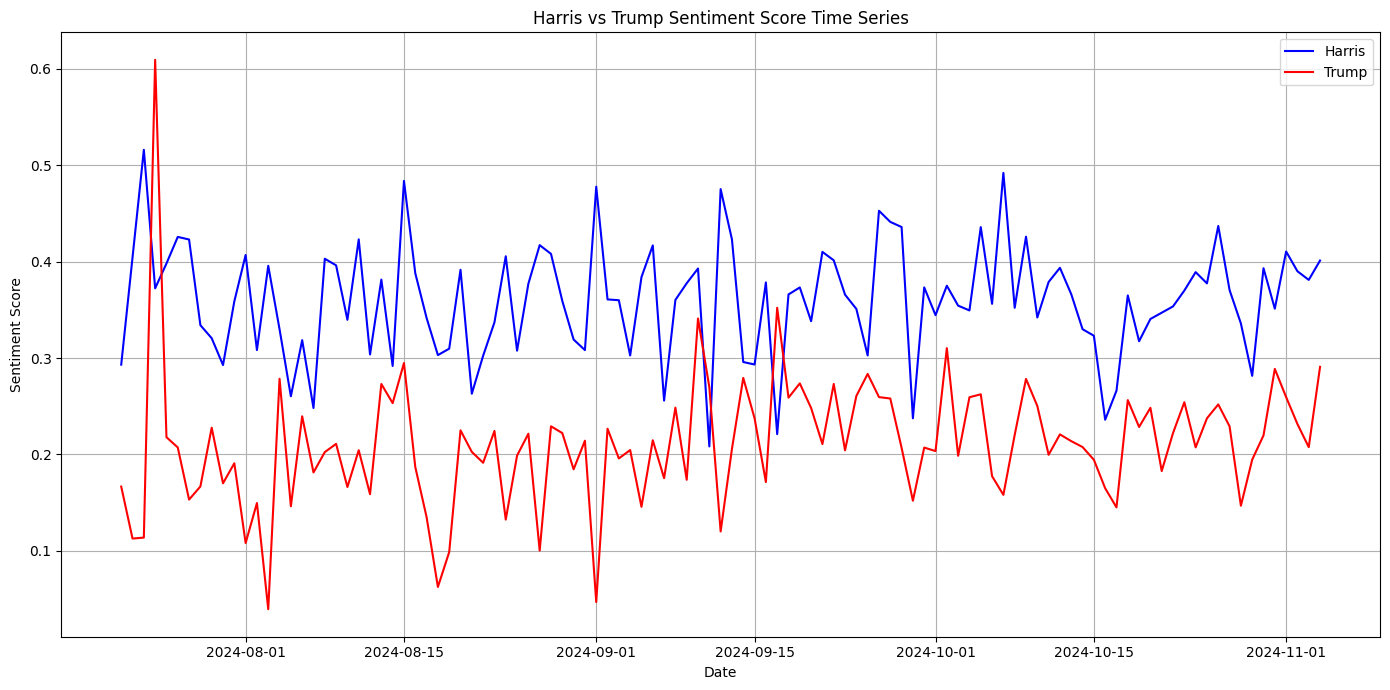

In [29]:
# 3. 파일 경로 설정
harris_time_series_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_harris_time_series.json"
trump_time_series_path = "/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/post_processing/llm_sentiment_analysis_trump_time_series.json"

# 4. JSON 파일 읽기 함수 정의
def read_time_series(json_path):
    """
    JSON 파일을 읽어 날짜별 sentiment score을 반환합니다.

    Args:
        json_path (str): JSON 파일의 경로

    Returns:
        pd.Series: 날짜를 인덱스로 하고 sentiment score을 값으로 하는 시리즈
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 날짜를 datetime 객체로 변환하고 정렬
    dates = []
    scores = []
    for date_str, score in data.items():
        try:
            date = datetime.strptime(date_str, '%Y-%m-%d')
            dates.append(date)
            scores.append(score)
        except ValueError as e:
            print(f"날짜 형식 오류 ({date_str}): {e}")
            continue

    # pandas 시리즈로 변환
    time_series = pd.Series(data=scores, index=dates)
    time_series = time_series.sort_index()

    return time_series

# 5. 데이터 읽기
print("Harris 데이터 읽는 중...")
harris_series = read_time_series(harris_time_series_path)
print("Trump 데이터 읽는 중...")
trump_series = read_time_series(trump_time_series_path)

# 6. 데이터프레임으로 결합 (날짜를 기준으로 병합)
combined_df = pd.DataFrame({
    'Harris Sentiment Score': harris_series,
    'Trump Sentiment Score': trump_series
})

# 7. 결측치 처리 (필요 시)
# 여기서는 결측치를 이전 값으로 채우는 방법을 사용
combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')

# 8. 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['Harris Sentiment Score'], color='blue', label='Harris')
plt.plot(combined_df.index, combined_df['Trump Sentiment Score'], color='red', label='Trump')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Harris vs Trump Sentiment Score Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 9. 그래프 출력
plt.show()